# **Lab 3: Convolutional Neural Network (CNN)**

In this lab we will continue working with the GTSRB dataset. However, we will go deeper. Adding linear layers and non-linear activations functions on top of each other. First, let's look at a re-implementation of what we had last time.

### 1. Implementing our own Softmax + CrossEntropyLoss function + Linear layer + Activation Function.
This is similar to the loss_softmax and loss_softmax_backward implementations in the previous lab. Here we also make sure this works for a batch of vectors instead of a single vector. This means the input here will be a tensor of size batchSize x inputSize:

In [1]:
# To avoid the speed problem of loading data from Google Drive, we will store and
# read the dataset NOT on your personal Google Drive, but on the temporary drive.
# This means that you have to put other necessary files such as lab_utils.py there
# as well. Before importing lab_util, just press the "Upload to a session storage"
# button from the menu on the left and upload lab_utils.py (and anything else you need).

In [2]:
import torch, lab_utils, random
from torchvision.datasets import GTSRB
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import json, string
%matplotlib inline

In [3]:
# This class combines Softmax + Cross Entropy Loss.
# Similar to the previous lab, but this implementation works for batches of inputs and
# not just individual input vectors. Here the input is batchSize x inputSize.
class nn_CrossEntropyLoss(object):
    # Forward pass -log softmax(input_{label})
    def forward(self, inputs, labels):
        max_val = inputs.max()  # This is to avoid variable overflows.
        exp_inputs = (inputs - max_val).exp()
        # This is different than in the previous lab. Avoiding for loops here.
        denominators = exp_inputs.sum(1).repeat(inputs.size(1), 1).t()
        self.predictions = torch.mul(exp_inputs, 1 / denominators)
        # Check what gather does. Just avoiding another for loop.
        return -self.predictions.log().gather(1, labels.view(-1, 1)).mean()

    # Backward pass
    def backward(self, inputs, labels):
        grad_inputs = self.predictions.clone()
        # Here we use a for loop (but it is avoidable too).
        for i in range(0, inputs.size(0)):
            grad_inputs[i][labels[i]] = grad_inputs[i][labels[i]] - 1
        return grad_inputs

# Input: 4 vectors of size 10.
testInput = torch.Tensor(4, 10).normal_(0, 0.1)
# labels: 4 labels indicating the correct class for each input.
labels = torch.LongTensor([3, 4, 4, 8])

# Forward and Backward passes:
loss_softmax = nn_CrossEntropyLoss()
loss = loss_softmax.forward(testInput, labels)
gradInputs = loss_softmax.backward(testInput, labels)

Next we provide an implementation for a linear layer that is also meant to work on batches of vectors. Notice that in addition to computing gradWeight and gradBias, we require here gradInput as we might need this gradient to do backpropagation. Making a batched implementation of this layer is easier because the only change is that now we have matrix-matrix multiplications as opposed to vector-matrix multiplications.

In [4]:
class nn_Linear(object):
    def __init__(self, inputSize, outputSize):
        self.weight = torch.Tensor(inputSize, outputSize).normal_(0, 0.01)
        self.gradWeight = torch.Tensor(inputSize, outputSize)
        self.bias = torch.Tensor(outputSize).zero_()
        self.gradBias = torch.Tensor(outputSize)

    # Forward pass, inputs is a matrix of size batchSize x inputSize
    def forward(self, inputs):
        # This one needs no change, it just becomes matrix x matrix multiplication
        # as opposed to just vector x matrix multiplication as we had before.
        return torch.matmul(inputs, self.weight) + self.bias

    # Backward pass, in addition to compute gradients for the weight and bias.
    # It has to compute gradients with respect to inputs.
    def backward(self, inputs, gradOutput):
        self.gradWeight = torch.matmul(inputs.t(), gradOutput)
        self.gradBias = gradOutput.sum(0)
        return torch.matmul(gradOutput, self.weight.t())

# Input: 4 vectors of size 3072.
testInput = torch.Tensor(4, 3 * 32 * 32).normal_(0, 0.1)
dummyGradOutputs = torch.Tensor(4, 10).normal_(0, 0.1)

#Forward and Backward passes:
linear = nn_Linear(3 * 32 * 32, 10)
output = linear.forward(testInput)
gradInput = linear.backward(testInput, dummyGradOutputs)

Finally we need to implement some non-linear activation function. Here we will implement ReLU which is the simplest activation function but also one of the most important as we discussed during class.

In [5]:
class nn_ReLU(object):
    # pytorch has an element-wise max function.
    def forward(self, inputs):
        outputs = inputs.clone()
        outputs[outputs < 0] = 0
        return outputs

    # Make sure the backward pass is absolutely clear.
    def backward(self, inputs, gradOutput):
        gradInputs = gradOutput.clone()
        gradInputs[inputs < 0] = 0
        return gradInputs

### 2. Implementation I: MLP classification using our implementations for GTSRB Dataset.
Now we are ready to use our three layers to build a neural network. We will use it to classify images in GTSRB as in our previous lab, but additionally we will use pytorch's DataLoaders which will build batches automatically for us, and will shuffle the data for us.

In [6]:
# In addition to transforming the image into a tensor, we also normalize the values in the image
# so that the mean pixel value is subtracted and divided by the pixel standard deviation.
imgTransform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # mean and std are for imagenet
                                   transforms.Resize((32,32)),
                                   transforms.Lambda(lambda inputs: inputs.view(3 * 32 * 32))])
trainset = GTSRB(root='./gtsrb_data', split='train', transform = imgTransform, download = True)
valset = GTSRB(root='./gtsrb_data', split='test', transform = imgTransform, download = True)

# Note here that we are not downloading to your personal Google Drive, but to a
# temporary colab drive so data loading won't be slow

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 128,
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 128,
                                        shuffle = False, num_workers = 0)

100%|██████████| 187490228/187490228 [00:42<00:00, 4416372.18it/s]


Extracting gtsrb_data/gtsrb/GTSRB-Training_fixed.zip to gtsrb_data/gtsrb


100%|██████████| 88978620/88978620 [00:08<00:00, 10133509.73it/s]


Extracting gtsrb_data/gtsrb/GTSRB_Final_Test_Images.zip to gtsrb_data/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 400490.14it/s]


Extracting gtsrb_data/gtsrb/GTSRB_Final_Test_GT.zip to gtsrb_data/gtsrb


Now that the dataset train, and validation splits are loaded, let's train.

In [7]:
from tqdm import tqdm as tqdm # This is a progress bar package that shows you how
# the training is going. You may need to install it first if it's not already
# installed: !pip3 install tqdm

learningRate = 1e-4  # Single learning rate for this lab.

# Definition of our network.
linear1 = nn_Linear(3 * 32 * 32, 1024)
relu = nn_ReLU()
linear2 = nn_Linear(1024, 43)
criterion = nn_CrossEntropyLoss()

# Training loop.
for epoch in range(0, 10):
    correct = 0.0
    cum_loss = 0.0
    counter = 0

    # Make a pass over the training data.
    t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
    for (i, (inputs, labels)) in enumerate(t):

        # Forward pass:
        a = linear1.forward(inputs)
        b = relu.forward(a)
        c = linear2.forward(b)
        cum_loss += criterion.forward(c, labels)
        max_scores, max_labels = c.max(1)
        correct += (max_labels == labels).sum()

        # Backward pass:
        grads_c = criterion.backward(c, labels)
        grads_b = linear2.backward(b, grads_c)
        grads_a = relu.backward(a, grads_b)
        linear1.backward(inputs, grads_a)

        # Weight and bias updates.
        linear1.weight = linear1.weight - learningRate * linear1.gradWeight
        linear1.bias = linear1.bias - learningRate * linear1.gradBias
        linear2.weight = linear2.weight - learningRate * linear2.gradWeight
        linear2.bias = linear2.bias - learningRate * linear2.gradBias

        # logging information.
        counter += inputs.size(0)
        t.set_postfix(loss = cum_loss.item() / (1 + i), accuracy = 100 * correct.item() / counter)

    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    counter = 0
    t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
    for (i, (inputs, labels)) in enumerate(t):

        # Forward pass:
        a = linear1.forward(inputs)
        b = relu.forward(a)
        c = linear2.forward(b)
        cum_loss += criterion.forward(c, labels)
        predicted = c.softmax(dim=1)
        max_vals, max_labels = predicted.max(dim = 1)
        correct += (max_labels == labels).sum()

        # logging information.
        counter += inputs.size(0)
        t.set_postfix(loss = cum_loss.item() / (1 + i), accuracy = 100 * correct.item() / counter)

Validation epoch 9: 100%|██████████| 99/99 [00:04<00:00, 23.84it/s, accuracy=71.9, loss=1.01] 


### 3. Implementation II: MLP classification using pytorch's nn functions for GTSRB Dataset.
Pytorch already comes with an impressive number of operations used to implement deep neural networks. Here we will use the same ones that we already have implemented and show how similar and easy is to use pytorch's implementations.





In [8]:
from tqdm import tqdm as tqdm

learningRate = 1e-2  # Single learning rate for this lab.

# Definition of our network.
network = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.ReLU(),
    nn.Linear(1024, 43),
)
#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10):
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        # Set the model in training mode.
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Calling backward on loss will compute all the gradients that lead
            # to it taking on its current value.
            loss.backward()

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.item()
            predicted = outputs.detach().softmax(dim=1)
            max_vals, max_labels = predicted.max(dim = 1)
            correct += (max_labels == labels).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct.item() / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        # Set the model in evaluation mode.
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.item()
            predicted = outputs.detach().softmax(dim=1)
            max_vals, max_labels = predicted.max(dim = 1)
            correct += (max_labels == labels).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct.item() / counter)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)

Validation epoch 9: 100%|██████████| 99/99 [00:04<00:00, 21.37it/s, accuracy=64.1, loss=1.36]


### 4. Convolutional Neural Networks (using Pytorch nn's) for GTSRB Dataset.
In this section we will use convolutional layers in addition to linear layers. Convolutional layers work on 2D input so we will modify our data loaders so that they return 2D images instead of the flattened array versions of the images that we have been using thus far.

In [9]:
# Same transformations as before but we do not vectorize the images.

# In addition to transforming the image into a tensor, we also normalize the values in the image
# so that the mean pixel value is subtracted and divided by the pixel standard deviation.
imgTransform = transforms.Compose([transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # mean and std are for imagenet
                                   ])
trainset = GTSRB(root='./gtsrb_data', split='train', transform = imgTransform, download = True)
valset = GTSRB(root='./gtsrb_data', split='test', transform = imgTransform, download = True)

# Note here that we are not downloading to your personal Google Drive, but to a
# temporary colab drive so data loading won't be slow

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 128,
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 128,
                                        shuffle = False, num_workers = 0)

Once data is loaded, now we proceed to define and train our neural network. Notice how we only need to change the definition of the model and not the way it is trained. This is just another of many advantages of training with a framework built on well engineered practices.

In [10]:
from tqdm import tqdm as tqdm

learningRate = 1e-2  # Single learning rate for this lab.

# LeNet is French for The Network, and is taken from Yann Lecun's 98 paper
# on digit classification https://ieeexplore.ieee.org/abstract/document/726791
# This was also a network with just two convolutional layers.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Linear layers.
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)

        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


# Definition of our network.
network = LeNet()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 20)

Validation epoch 19: 100%|██████████| 99/99 [00:03<00:00, 29.82it/s, accuracy=72.5, loss=1.26]


The last model achieved some more impressive numbers than the accuracies we were obtaining in our previous lab by a large margin. The last model seems to be still improving, maybe training it for more epochs, or under a different learning rate, or reducing the learning rate after the first 20 epochs, could improve the accuracy further. We could try all these things. We should also from time to time, test our model on a few inputs and see how good it is becoming.

In [3]:
classes = ['20','30','50','60','70','80','End of speed limit 80', '100', '120',
           'No passing','No passing for vehicles over 3,5 tonnes','Priority','Priority road','Yield','stop','Road closed','Vehicles over 3.5 tonnes prohibited','Do not enter',
           'General danger','Left curve','Right curve','Double curve','Uneven road surface','Slippery','Road narrows','Roadworks','Traffic signals ahead',
           'Pedestrian crossing','Watch for children','Bicycle crossing','Ice / snow', 'Deer','End of all restrictions','Turn right ahead','Turn left ahead','Ahead only',
           'Ahead or turn right only','Ahead or turn left only','Pass by on right','Pass by on left','Roundabout','End of no passing zone','End of no passing zone for trucks	']
un_normalize = lab_utils.UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

network.eval()  # Important!

# Now predict the category using this trained classifier
for i in range(0, 5):
    img_id = random.randint(0, 10000)
    print('Image %d' % img_id)
    img, _ = valset[img_id]
    predictions = F.softmax(network(img.unsqueeze(0)),dim = 1)
    predictions = predictions

    # Show the results of the classifier.
    lab_utils.show_image(lab_utils.tensor2pil(un_normalize(img)).resize((128, 128)));
    max_score, max_label = predictions.max(1)
    print('Image predicted as %s with confidence %.2f' % (classes[max_label[0]], max_score[0]))

    # Print out detailed predictions.
    for (i, pred) in enumerate(predictions.squeeze().tolist()):
        print('y_hat[%s] = %.2f' % (classes[i], pred))

NameError: name 'network' is not defined

### 5. Pytorch's pretrained Convolutional Neural Networks.
Pytorch has several pretrained Convnet models in the Imagenet Large Scale Visual Recognition Challenge (ILSVRC) dataset. The ILSVRC task contains more than 1 million images in the training set, and the number of labels is 1000. Training a Convnet on this dataset takes often weeks on arrays of GPUs. Let's load one of such networks called AlexNet.
You can see a list of available models for different tasks and their details here: https://pytorch.org/vision/stable/models.html

In [4]:
from torchvision.models.alexnet import AlexNet_Weights
# Load the pre-trained AlexNet model
network = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

print(network)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/shenshi/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 84.6MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

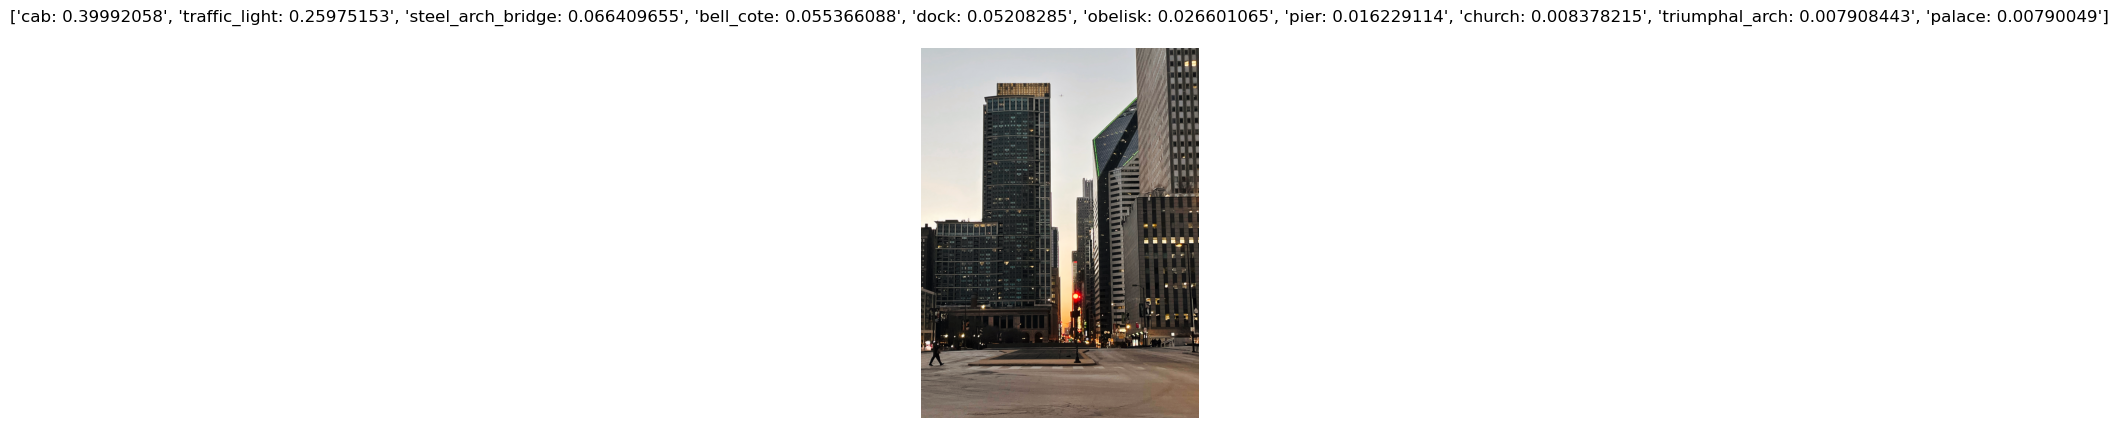

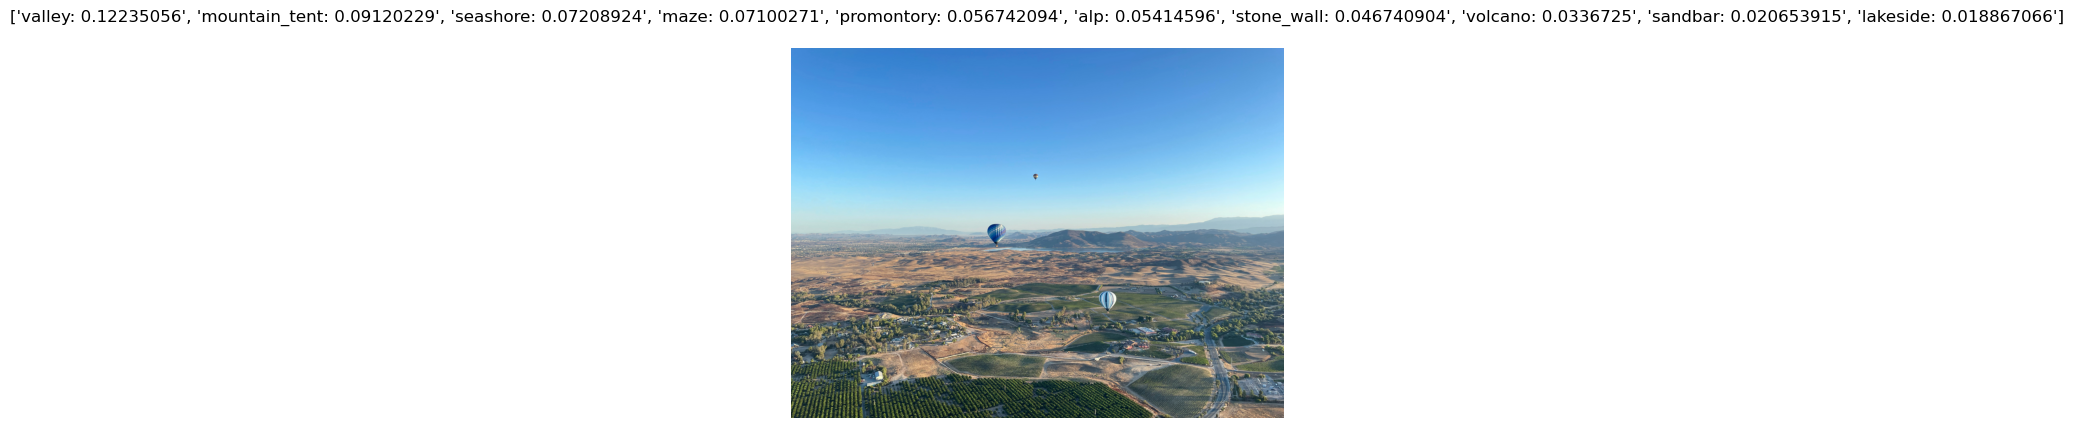

In [7]:
# 1. Define the appropriate image pre-processing function.
preprocessFn = transforms.Compose([transforms.Resize(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('imagenet_class_index.json')).items()}

# 3. Forward a test image.
# Don't forget to set in evaluation mode so dropoff layers don't add randomness.
network.eval()
# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image1 = Image.open('1.jpg').convert('RGB')
image2 = Image.open('2.jpg').convert('RGB')
# Try your own image here.

def alexnet_predict(image):
  inputVar =  preprocessFn(image).unsqueeze(0)
  predictions = network(inputVar)

  # Decode the top 10 classes predicted for this image.
  # We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
  probs, indices = (-F.softmax(predictions,dim = 1)).sort()
  probs = (-probs).detach().numpy()[0][:10]; indices = indices.numpy()[0][:10]
  preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

  # 5. Show image and predictions
  plt.figure()
  plt.title(str(preds)+'\n')
  plt.axis('off')
  plt.imshow(image);

alexnet_predict(image1)
alexnet_predict(image2)

### 6. Fine-tuning AlexNet on GTSRB Dataset

We will now use a pretrained Alexnet on GTSRB data, however there is a problem which is that Alexnet takes images in 224x224 resolution, and GTSRB images are different sizes. So we will scale-up images in GTSRB so that they work with Alexnet.


In [8]:
imgTransform = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ])
trainset = GTSRB(root='./gtsrb_data', split='train', transform = imgTransform, download = True)
valset = GTSRB(root='./gtsrb_data', split='test', transform = imgTransform, download = True)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 64,
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 64,
                                        shuffle = False, num_workers = 0)

The code below will be extremely slow on a CPU, hours per epoch, and maybe a week to finish all epochs. For this part you will need GPU nodes in the cloud (AWS, Google Cloud) or your own GPU (gaming laptop). In Google Colab, you can use GPU from Runtime>Change Runtime Type and choosing GPU. Just be sure to change your runtime type back to CPU when you are not using GPU. This is because Google Colab will limit your access to GPU if you use it too much. Running the code below on Colab GPU should take a little less than 10 minutes. Another thing is that GPUs do not have a lot of memory so batch size 128 is also not going to be possible.

Here is a list of other free GPU resources that you can use both for your labs as well as your course projects:

https://answers.uillinois.edu/illinois/page.php?id=122558

In [10]:
from tqdm import tqdm as tqdm

#!pip install livelossplot --quiet
from livelossplot import PlotLosses

def train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        network = network.to(device)
        criterion = criterion.to(device)

    # Keep track of best accuracy so far.
    best_accuracy = 0
    liveloss = PlotLosses()

    # Training loop.
    for epoch in range(0, n_epochs):
        logs = {}
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        # Set the model in training mode.
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):

            if use_gpu:
                inputs = inputs.to(device)
                labels = labels.to(device)

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Calling backward on loss will compute all the gradients that lead
            # to it taking on its current value.
            loss.backward()

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.item()
            predicted = outputs.detach().softmax(dim=1)
            max_vals, max_labels = predicted.max(dim = 1)
            correct += (max_labels == labels).sum().cpu().item()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

            # Keep track of loss and accuracy for the plot.
            n_batches = 1 + i
            logs['loss'] = cum_loss / n_batches
            logs['accuracy'] = correct / counter

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        # Set the model in evaluation mode.
        network.eval()  # This is important to call before evaluating!

        # No need to keep track of gradients for this part.
        with torch.no_grad():
          for (i, (inputs, labels)) in enumerate(t):

              if use_gpu:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

              # Forward pass:
              outputs = network(inputs)
              loss = criterion(outputs, labels)

              # logging information.
              cum_loss += loss.item()
              predicted = outputs.detach().softmax(dim=1)
              max_vals, max_labels = predicted.max(dim = 1)
              correct += (max_labels == labels).sum().cpu().item()
              counter += inputs.size(0)
              t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

              # Keep track of loss and accuracy for the plot.
              n_batches = 1 + i
              logs['val_loss'] = cum_loss / n_batches
              logs['val_accuracy'] = correct / counter

        # Save the parameters for the best accuracy on the validation set so far.
        if logs['val_accuracy'] > best_accuracy:
            best_accuracy = logs['val_accuracy']
            torch.save(network.state_dict(), 'best_model_so_far.pth')

        # Update the plot with new logging information.
        liveloss.update(logs)
        liveloss.send()

        # What is this for? Please look it up.
        if scheduler != -1:
            scheduler.step()

    # Load the model parameters for the one that achieved the best val accuracy.
    # network.load_state_dict(torch.load('best_model_so_far.pth'))

In [15]:
learningRate = 1e-3  # Single learning rate for this lab.

# Defining as global the device to use (by default CPU).
device = torch.device("cpu")

# Definition of our network.
from torchvision.models.alexnet import AlexNet_Weights
# Load the pre-trained AlexNet model
network = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
# Also notice we are replacing the classifier which originally has 3 linear layers
# into a classifier that is just a single layer.
network.classifier = nn.Linear(9216, 43)  # GTSRB has 43 classes not 1000.

# Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

# Train the previously defined model.
train_model(network, criterion, optimizer, -1, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:  32%|███▏      | 134/417 [03:45<07:56,  1.68s/it, accuracy=48.9, loss=2.03]


KeyboardInterrupt: 

## Lab Questions (10pts+2pts bonus)

1) [2pts] In section 1 of this lab we implemented the ReLU activation function, and used it to train a two-layer neural network. Here please implement Sigmoid, and TanH:

$$\text{Sigmoid(x)} = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}$$

$$\text{Tanh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

In [ ]:
# Sigmoid of x.
class nn_Sigmoid:
    def forward(self, x):
        # Forward pass.
        pass

    def backward(self, x, gradOutput):
        # Backward pass
        pass

# Hyperbolic tangent.
class nn_Tanh:
    def forward(self, x):
        # Forward pass.
        pass

    def backward(self, x, gradOutput):
        # Backward pass
        pass

2) [1pts] Our ReLU function makes things zero when they are less than zero. This is still the most widely used activation function used today but a variante called LeakyReLU has been proposed where a linear function close to zero is used instead. Here is the definition:

$$ \text{LeakyReLU}(x) = \begin{cases}
      \beta x & x < 0 \\
      x & x \geq 0
\end{cases}$$

where $\beta$ is usally a small value e.g. $\beta = 0.3$

In [ ]:
# Sigmoid of x.
class nn_LeakyReLU:
    def __init__(self, beta = 0.3):
        self.beta = beta

    def forward(self, x):
        # Forward pass.
        pass

    def backward(self, x, gradOutput):
        # Backward pass
        pass

3) [2pts] For the GTSRB dataset, list the training and validation accuracies of the linear classifier in Lab 2, MLP (section 3), LeNet (section 4), and fine-tuned Alexnet (section 6). Also, list the time that it takes to train and evaluate one epoch of each (mention if the reported time is using CPU or GPU). Finally, list the number of unknown parameters in each model. Summarize your findings and comment on the capabilities of each moel. Present your results in the form of a table using the markdown code provided below.

| **Header 1** | Header 2 | Header 3 |
|--------------|----------|----------|
| **Row 1 Col 1** | Row 1 Col 2 | Row 1 Col 3 |
| **Row 2 Col 1** | Row 2 Col 2 | Row 2 Col 3 |
| **Row 3 Col 1** | Row 3 Col


 4) [3pts] Propose a new convolutional neural network that obtains at least **85% accuracy** on the GTSRB validation set. Show here the code for your network, and a plot showing the training accuracy, validation accuracy, and another one with the training loss, and validation loss (similar plots as in our previous lab). Included below is the LeNet implementation that you can use as a starting point. The answer to this question includes reporting the maximum validation accuracy achieved [here](https://docs.google.com/spreadsheets/d/14dC0G6s8itEQNoq_yTWd5ug8L7KNL4I55MojJnOMj3A/edit?usp=sharing).

In [ ]:
from tqdm import tqdm as tqdm

learningRate = 1e-2  # Feel free to change this.

# You can use LeNet as the starting point.
# You can do things such as adding more layers,
# adding more filters to the existing layers,
# changing learning rate and other hyperparameters,
# adding things such as BatchNormalization, Dropout, etc.
# anything you want, including getting inspiration from famous architectures,
# but add references if you consult something online.

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Linear layers.
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)

        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


# Definition of our network.
network = MyNetwork()

# Feel free to use a different loss here.
criterion = nn.CrossEntropyLoss()

# Feel free to change the optimizer, or the optimizer parameters. e.g. momentum, weightDecay, etc.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

# Train the previously defined model.
train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 20)


## This is how you can count the number of parameters
## in a neural network in pytorch in a generic way.
#
#count_params = 0
#for param in model.parameters():
#  count_params += param.numel()
#print(count_params)

5) [2pts] Take 10 traffic sign images with your phone and download 10 images from the internet. Use your trained model in Q4 on them, show the image and the model's top 10 predictions (see example in section 5 of this tutorial), and report your accuracy on the 20 images.

In [ ]:
# Your code here.

### Bonus/Optional

1) [2pts] A simpler (less time consuming) approach to using a pre-trained CNN is to use it as a feature extractor. In this strategy we would use the Resnet 18 network to compute "features" of the images, and then train a simple softmax classifier on top of those features. We could for instance remove the "fc" layer from the model, and use the 512-dimensional output of the network as our "features" for each image. Then we train a softmax classifier using these 512-dimensional vectors as inputs. Train such a classifier here for the traffic sign detection task, and present model, plots, and a few example classifications on the validation set. Note: In this task, since we only run the forward pass of Resnet once for each image, we might be able to get away doing this optional part without a GPU.